## Wikipedia Articles Clustering (NLP)
`EDA (Exploratory Data Analysis)`

**Abstract**: We load data from The 20 newsgroups text dataset, which comprises around 18,000 newsgroups posts on 20 topics. For illustrative purposes and to reduce the computational cost, we select a subset of 4 topics only accounting for around 3,400 documents. See the example Classification of text documents using sparse features to gain intuition on the overlap of such topics. <br>
**Source**: https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn import metrics
from time import time
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
# nltk.download('stopwords')

In [2]:
# Initial setting
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', None)

In [3]:
# Loading the Data
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [4]:
# Building a DataFrame structure
df = pd.DataFrame([dataset.data, dataset.target.tolist()]).T
df.columns = ['text', 'target']

# Gathering the target names indexes
targets = pd.DataFrame(dataset.target_names)
targets.columns=['title']

# Joining all the data into a single dataset
out = pd.merge(df, targets, left_on='target', right_index=True)
out.head()

,text,target,title
0,My point is that you set up your views as the only way to believe. Saying \nthat all eveil in t...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pretty weak. Comparison of the\n]current hebrew tex...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and you certainly couldn't judge\nit subjectively. A...",0,alt.atheism
26,"\n\nWell I agree with you in the sense that they have no ""moral"" right to inflict\nthese rules, ...",0,alt.atheism
27,"\n\nSpecifically, which changes are you talking about? Are you arguing\nthat the motto is inter...",0,alt.atheism


### Feature Extraction using TfidfVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer application
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.331 s
n_samples: 3387, n_features: 7929


In [6]:
# Fulfillness
print(f"We find that around {round(X_tfidf.nnz / np.prod(X_tfidf.shape)*100, 2):.2f}% of the entries of the X_tfidf matrix are non-zero")

We find that around 0.69% of the entries of the X_tfidf matrix are non-zero


### Performing dimensionality reduction using LSA

We use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

# Set searborn
# sns.set()

# Instance of SVD
svd = TruncatedSVD(X_tfidf.shape[1] - 1)

# Making a pipeline for applying LSA (dimensionality reduction), and normalizing the data
pipeline = make_pipeline(svd, Normalizer(copy=False))

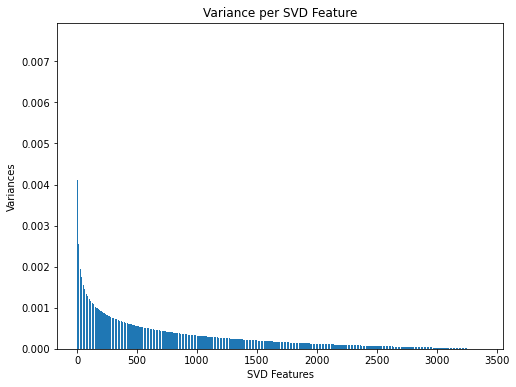

In [8]:
# Pipeline Fit
pipeline.fit(X_tfidf)

# LSA plot - Explained Variance Ratio
features  = range(1, len(svd.components_))
plt.figure(figsize=(8, 6))
plt.bar(features, svd.explained_variance_ratio_[1:])
plt.xlabel('SVD Features')
plt.ylabel('Variances')
plt.title('Variance per SVD Feature')
# plt.xticks(features, rotation= 90)
plt.show()

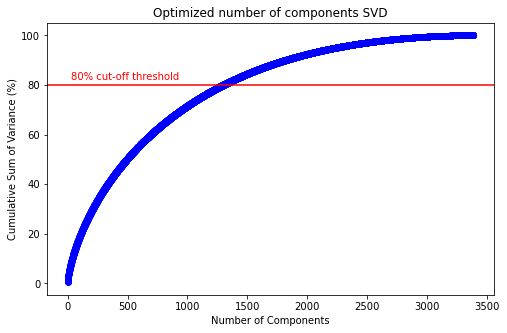

In [9]:
# Plotting the result
plt.figure(figsize=(8, 5))

# Alternative way to upgrade the procedure performed above
plt.plot(range(0, X_tfidf.shape[0]), svd.explained_variance_ratio_.cumsum()*100, marker= 'o', linestyle = '--', color = 'b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum of Variance (%)')
plt.title('Optimized number of components SVD')
# plt.xticks(np.arange(0, max(variance['index']), step=1), rotation = 90) #change from 0-based array index to 1-based human-readable label

plt.axhline(y= 80, color='r', linestyle='-')
plt.text(30, 82, '80% cut-off threshold', color = 'red', fontsize=10)

plt.show()

In [10]:
# List of explained variances
tsvd_var_ratios = svd.explained_variance_ratio_

In [11]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [12]:
# Run function
print(f'Optimized number of components: {select_n_components(tsvd_var_ratios, 0.80)}')

Optimized number of components: 1298


In [13]:
# Using the optimized number of components
lsa = make_pipeline(TruncatedSVD(n_components= select_n_components(tsvd_var_ratios, 0.80)), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 18.794 s
Explained variance of the SVD step: 79.7%


In [14]:
# For LSA, a value of 100 is recommended by the literature
lsa = make_pipeline(TruncatedSVD(n_components= 100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.352 s
Explained variance of the SVD step: 18.4%


### Performing K-Means clustering

We'll use the `Elbow Method` to define the optimized number of clusters, as follows

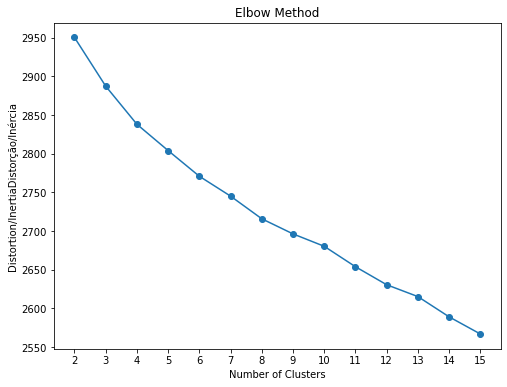

In [15]:
# Initializing parameters
ks = range(2, 16)
inertias = []
n_cluster = []
ss_indexes = []

for k in ks:
    # K-Means instance
    model = KMeans(n_clusters = k, random_state= 12345)
    
    # Model Fit
    model.fit(X_lsa)
    
    # Inertia and labels append
    inertias.append(model.inertia_)
    labels = model.labels_
        
    # Silhouette Score
    ss_index = metrics.silhouette_score(X_lsa, labels)
    n_cluster.append(k)
    ss_indexes.append(ss_index)

# Building the dataframe containing number of cluster per Silhouette Score
df_ss = pd.DataFrame({'n_cluster': n_cluster, 'ss_indexes': ss_indexes})
    
# Plot ks vs inertias
plt.figure(figsize=(8, 6))
plt.plot(ks, inertias, '-o');
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion/InertiaDistorção/Inércia')
plt.title('Elbow Method')
plt.xticks(ks)
plt.show();

Considering the intersection of the tangent lines of the curve above we can consider **4 (FOUR)** as the `Optimized Number of Clusters` illustrated above

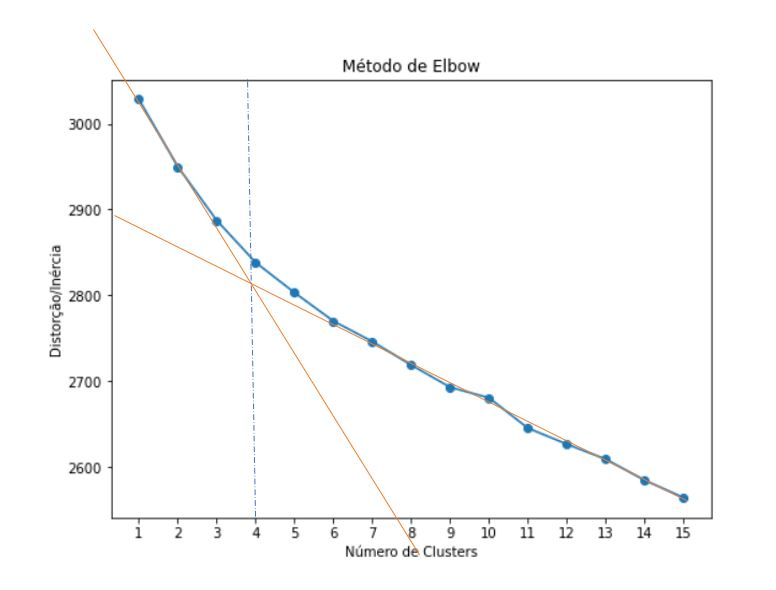

In [16]:
from IPython.display import Image
Image(filename= r"C:\Users\016529631\Pictures\elbow method.JPG",
     width = 500,
     height = 200)

Another alternative way corresponds to the use of the `Silhouette Score` for defining the optimal cluster number

In [17]:
# Local Maximum procedure
from scipy.signal import argrelextrema

# Collecting local maxima
max_ind = argrelextrema(df_ss['ss_indexes'].to_numpy(), np.greater)
n_clusters = df_ss['n_cluster'].iloc[max_ind].max()

# If there are no local maxima, the optimized number of clusters is defined according to the global maximum, 
# that is, considering the extremities
if np.isnan(n_clusters):
    n_clusters = df_ss.loc[df_ss['ss_indexes'] == df_ss['ss_indexes'].max()]['n_cluster'].to_list()[0]

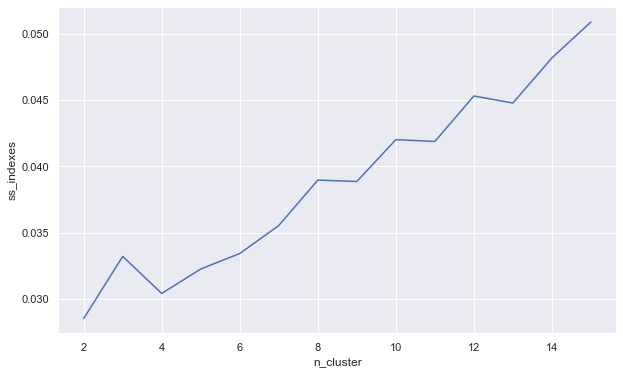

In [18]:
# Plotting figure
sns.set(rc = {'figure.figsize':(10, 6)})
sns.lineplot(data = df_ss, x = 'n_cluster', y = 'ss_indexes', legend = 'brief');

### K-Means model output

In [19]:
# K-Means instance
kmeans = KMeans(n_clusters = 4, random_state= 12345)

# Model Fit
kmeans.fit(X_lsa)

KMeans(n_clusters=4, random_state=12345)

In [20]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: don think people just like know say time religion did 
Cluster 1: space launch orbit nasa shuttle earth moon like mission just 
Cluster 2: thanks graphics image program know file files looking software does 
Cluster 3: god jesus bible believe say faith people christian does belief 
